# Reshaping data for model
In this file, we will take the data that has been gathered and harmonized and we will fit it, create scenarios, and save it as a structured array for the model. Since we would like to keep the flexibility with excel, we will also save it in an ODYM compatible format and create a file that can do the reverse: if teh excel file is eddited, so is the array. This will be a separate script.

In [1]:
# Load a local copy of the current ODYM branch:
import sys
import os
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from seaborn.palettes import color_palette
import xlrd
import pylab
from copy import deepcopy
import logging as log
import xlwt
import tqdm
import math
from scipy.stats import norm
from tqdm import tqdm
from scipy.optimize import curve_fit
import matplotlib
from logistic import logistic as logistic
mpl_logger = log.getLogger("matplotlib")
mpl_logger.setLevel(log.WARNING)  
# For Ipython Notebook only
### Preamble
# Going to parent path
os.getcwd()
os.chdir("..")
os.chdir("..")

# add ODYM module directory to system path, relative
MainPath = os.path.join(os.getcwd(), 'odym', 'modules')
sys.path.insert(0, MainPath)

# add ODYM module directory to system path, absolute
sys.path.insert(0, os.path.join(os.getcwd(), 'odym', 'modules'))

# Specify path to dynamic stock model and to datafile, relative
DataPath = os.path.join( 'docs', 'files')

# Specify path to dynamic stock model and to datafile, absolute
DataPath = os.path.join(os.getcwd(), 'docs', 'Files')

import ODYM_Classes as msc # import the ODYM class file
import ODYM_Functions as msf # import the ODYM function file
import dynamic_stock_model as dsm # import the dynamic stock model library

# Initialize loggin routine
log_verbosity = eval("log.DEBUG")
log_filename = 'LogFileTest.md'
[Mylog, console_log, file_log] = msf.function_logger(log_filename, os.getcwd(),
                                                     log_verbosity, log_verbosity)
Mylog.info('### 1. - Initialize.')

#Read main script parameters
#Load project-specific config file
ProjectSpecs_ConFile = 'ODYM_Config_Vehicle_System.xlsx'
Model_Configfile     = xlrd.open_workbook(os.path.join(DataPath, ProjectSpecs_ConFile))
ScriptConfig         = {'Model Setting': Model_Configfile.sheet_by_name('Config').cell_value(3,3)} # Dictionary with config parameters
Model_Configsheet    = Model_Configfile.sheet_by_name('Setting_' + ScriptConfig['Model Setting'])

Name_Scenario        = Model_Configsheet.cell_value(3,3)
print(Name_Scenario)

#Read control and selection parameters into dictionary
ScriptConfig         = msf.ParseModelControl(Model_Configsheet,ScriptConfig)

Mylog.info('Read and parse config table, including the model index table, from model config sheet.')
IT_Aspects,IT_Description,IT_Dimension,IT_Classification,IT_Selector,IT_IndexLetter,\
PL_Names,PL_Description,PL_Version,PL_IndexStructure,PL_IndexMatch,PL_IndexLayer,\
PrL_Number,PrL_Name,PrL_Comment,PrL_Type,ScriptConfig = msf.ParseConfigFile(Model_Configsheet,ScriptConfig,Mylog)    

class_filename       = 'ODYM_Classifications_Master_Vehicle_System.xlsx'
Classfile            = xlrd.open_workbook(os.path.join(DataPath,class_filename))
Classsheet           = Classfile.sheet_by_name('MAIN_Table')
MasterClassification = msf.ParseClassificationFile_Main(Classsheet,Mylog)


Mylog.info('Define model classifications and select items for model classifications according to information provided by config file.')
ModelClassification  = {} # Dict of model classifications
for m in range(0,len(IT_Aspects)):
    ModelClassification[IT_Aspects[m]] = deepcopy(MasterClassification[IT_Classification[m]])
    EvalString = msf.EvalItemSelectString(IT_Selector[m],len(ModelClassification[IT_Aspects[m]].Items))
    if EvalString.find(':') > -1: # range of items is taken
        RangeStart = int(EvalString[0:EvalString.find(':')])
        RangeStop  = int(EvalString[EvalString.find(':')+1::])
        ModelClassification[IT_Aspects[m]].Items = ModelClassification[IT_Aspects[m]].Items[RangeStart:RangeStop]           
    elif EvalString.find('[') > -1: # selected items are taken
        ModelClassification[IT_Aspects[m]].Items = [ModelClassification[IT_Aspects[m]].Items[i] for i in eval(EvalString)]
    elif EvalString == 'all':
        None
    else:
        Mylog.error('Item select error for aspect ' + IT_Aspects[m] + ' were found in datafile.')
        break

# Define model index table and parameter dictionary
Mylog.info('### 2.2 - Define model index table and parameter dictionary')
Model_Time_Start = int(min(ModelClassification['Time'].Items))
Model_Time_End   = int(max(ModelClassification['Time'].Items))
Model_Duration   = Model_Time_End - Model_Time_Start + 1

Mylog.info('Define index table dataframe.')
IndexTable = pd.DataFrame({'Aspect'        : IT_Aspects,  # 'Time' and 'Element' must be present!
                           'Description'   : IT_Description,
                           'Dimension'     : IT_Dimension,
                           'Classification': [ModelClassification[Aspect] for Aspect in IT_Aspects],
                           'IndexLetter'   : IT_IndexLetter})  # Unique one letter (upper or lower case) indices to be used later for calculations.

# Default indexing of IndexTable, other indices are produced on the fly
IndexTable.set_index('Aspect', inplace=True)

# Add indexSize to IndexTable:
IndexTable['IndexSize'] = pd.Series([len(IndexTable.Classification[i].Items) for i in range(0, len(IndexTable.IndexLetter))],
                                    index=IndexTable.index)

# list of the classifications used for each indexletter
IndexTable_ClassificationNames = [IndexTable.Classification[i].Name for i in range(0, len(IndexTable.IndexLetter))]


# Define dimension sizes
Nt = len(IndexTable.Classification[IndexTable.index.get_loc('Time')].Items)
Nc = len(IndexTable.Classification[IndexTable.index.get_loc('Age-cohort')].Items)
Ng = len(IndexTable.Classification[IndexTable.index.get_loc('Drive_train')].Items)
Ne = len(IndexTable.Classification[IndexTable.index.get_loc('Element')].Items)
Nb = len(IndexTable.Classification[IndexTable.index.get_loc('Battery_Chemistry')].Items)
Ns = len(IndexTable.Classification[IndexTable.index.get_loc('Size')].Items)
Nh = len(IndexTable.Classification[IndexTable.index.get_loc('Recycling_Process')].Items)
NS = len(IndexTable.Classification[IndexTable.index.get_loc('EV_penetration_scenario')].Items)
Na = len(IndexTable.Classification[IndexTable.index.get_loc('Chemistry_Scenarios')].Items)
Nz = len(IndexTable.Classification[IndexTable.index.get_loc('Stock_Scenarios')].Items)
NR = len(IndexTable.Classification[IndexTable.index.get_loc('Reuse_Scenarios')].Items)
NE = len(IndexTable.Classification[IndexTable.index.get_loc('Energy_Storage_Scenarios')].Items)
Nv = len(IndexTable.Classification[IndexTable.index.get_loc('V2G_Scenarios')].Items)

INFO (<ipython-input-1-fe30fc3b3d14> <<module>>): ### 1. - Initialize.
INFO (<ipython-input-1-fe30fc3b3d14> <<module>>): Read and parse config table, including the model index table, from model config sheet.
INFO (ODYM_Functions.py <ParseConfigFile>): Read parameter list from model config sheet.
INFO (ODYM_Functions.py <ParseConfigFile>): Read process list from model config sheet.
INFO (ODYM_Functions.py <ParseConfigFile>): Read model run control from model config sheet.
INFO (ODYM_Functions.py <ParseConfigFile>): Read model output control from model config sheet.
INFO (ODYM_Functions.py <ParseClassificationFile_Main>): End of file or formatting error while reading the classification file in column 16. Check if all classifications are present. If yes, you are good to go!
INFO (<ipython-input-1-fe30fc3b3d14> <<module>>): Define model classifications and select items for model classifications according to information provided by config file.
INFO (<ipython-input-1-fe30fc3b3d14> <<module>

Vehicle stock model for European fleet


### Importing datasheet with targets to make fits

In [2]:
# Defining path to raw data
data_path = os.path.join(os.getcwd(), 'data', 'raw_data')

In [32]:
# Importing data
df = pd.read_excel(data_path+'/V2G_scenarios.xlsx')
# df.head()
with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.precision', 20,
                       ):
    print(df)

       Scenario Drive_train  Time                   value
0        No V2G         BEV  2020  0.00000000000000000000
1        No V2G         BEV  2030  0.00000000000000000000
2        No V2G         BEV  2050  0.00000000000000000000
3           Low         BEV  2020  0.00000000000000000000
4           Low         BEV  2030  0.10000000000000000555
5           Low         BEV  2050  0.20000000000000001110
6      Moderate         BEV  2020  0.00000000000000000000
7      Moderate         BEV  2030  0.17499999999999998890
8      Moderate         BEV  2050  0.29999999999999998890
9          High         BEV  2020  0.00000000000000000000
10         High         BEV  2030  0.26500000000000001332
11         High         BEV  2050  0.69999999999999995559
12  V2G mandate         BEV  2020  0.00000000000000000000
13  V2G mandate         BEV  2028  0.11999999999999999556
14  V2G mandate         BEV  2031  0.50000000000000000000
15  V2G mandate         BEV  2035  0.88000000000000000444
16  V2G mandat

In [5]:
df['Scenario'].unique()

array(['No V2G', 'Low', 'Moderate', 'High', 'V2G mandate', 'Early'],
      dtype=object)

### Creating logistic fits

In [33]:
# Create logistic fits
t = np.arange(1950,2051)
fit = np.zeros((6, Ng,Nt))
for i,s in enumerate(df['Scenario'].unique()):
            popt, pcov = curve_fit(logistic, df.loc[(df['Scenario']==s) & (df['Drive_train']=='BEV'), 'Time'].values, df.loc[(df['Scenario']==s) & (df['Drive_train']=='BEV'), 'value'].values, bounds=([2020, 0., 0, 0], [2050, 10, 1, 1])) # Bounds are set as ([low_ti, low_tau, low_Co, low_C1],[high_ti,high_tau, high_Co, high_C1 ])
            fit[i,1,:] = logistic(t, *popt)


C:\Users\lauinger\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


### Plotting results

Text(0.5, 0, 'Year')

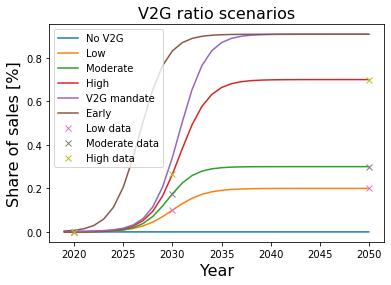

In [34]:
MyColorCycle = pylab.cm.Paired(np.arange(0,1,0.1)) # select 10 colors from the 'Paired' color map.
fig, ax = plt.subplots()
ax.plot(t[69:], fit[0,1,69:],label='No V2G')
ax.plot(t[69:], fit[1,1,69::], label='Low')
ax.plot(t[69:], fit[2,1,69:], label='Moderate')
ax.plot(t[69:], fit[3,1,69:],label='High')
ax.plot(t[69:], fit[4,1,69:], label='V2G mandate')
ax.plot(t[69:], fit[5,1,69:],label='Early')
ax.plot(df.loc[(df['Scenario']=='Low') & (df['Drive_train']=='BEV'), 'Time'].values, df.loc[(df['Scenario']=='Low') & (df['Drive_train']=='BEV'), 'value'].values, 'x', label='Low data')
ax.plot(df.loc[(df['Scenario']=='Moderate') & (df['Drive_train']=='BEV'), 'Time'].values, df.loc[(df['Scenario']=='Moderate') & (df['Drive_train']=='BEV'), 'value'].values,'x',label='Moderate data')
ax.plot(df.loc[(df['Scenario']=='High') & (df['Drive_train']=='BEV'), 'Time'].values, df.loc[(df['Scenario']=='High') & (df['Drive_train']=='BEV'), 'value'].values,'x',label='High data')
ax.legend( loc='best',prop={'size':10})
ax.set_ylabel('Share of sales [%]',fontsize =16)
ax.set_title('V2G ratio scenarios'.format(s), fontsize=16)
ax.set_xlabel('Year',fontsize =16)

## Preparing V2G ratio
Since the aim of V2G is to make use of oversized and underused LIBs, we assume that only BEVs participate in the V2G market. 
We define scenarios for the V2G penetration which apply only to BEVs and that change over time. 

In [35]:
V2GArray = np.zeros((Nv,Ng,Nt))

In [36]:
# Defining empty DataFrame with the desired dimensions
lp0, lp1, lp2 = pd.core.reshape.util.cartesian_product([IndexTable.Classification[IndexTable.index.get_loc('V2G_Scenarios')].Items,IndexTable.Classification[IndexTable.index.get_loc('Drive_train')].Items, IndexTable.Classification[IndexTable.index.get_loc('Time')].Items])
data = pd.DataFrame(dict(Scenario= lp0, Drive_train=lp1, Time=lp2))

### Add values to dataframe and fill with zeroes if NaN

In [37]:
data.loc[(data['Drive_train']=='BEV') & (data['Scenario']=='No V2G'), 'value'] = 0
data.loc[(data['Drive_train']=='BEV') & (data['Scenario']=='Low'), 'value'] = fit[1,1,:]
data.loc[(data['Drive_train']=='BEV') & (data['Scenario']=='Medium'), 'value'] = fit[3,1,:]
data.loc[(data['Drive_train']=='BEV') & (data['Scenario']=='V2G mandate'), 'value'] = fit[4,1,:]


In [38]:
data.fillna(0, inplace=True)

In [39]:
# define results path
results_path = os.path.join(os.getcwd(), 'data', 'scenario_data')

In [40]:
# Save as excel for overview
data.to_excel(results_path+'/V2G_ratio.xlsx')

In [41]:
data.loc[data['Drive_train']=='BEV']

,Scenario,Drive_train,Time,value
101,No V2G,BEV,1950.0,0.000000
102,No V2G,BEV,1951.0,0.000000
103,No V2G,BEV,1952.0,0.000000
104,No V2G,BEV,1953.0,0.000000
105,No V2G,BEV,1954.0,0.000000
...,...,...,...,...
1409,V2G mandate,BEV,2046.0,0.908278
1410,V2G mandate,BEV,2047.0,0.908285
1411,V2G mandate,BEV,2048.0,0.908289
1412,V2G mandate,BEV,2049.0,0.908290


In [42]:
for m in range(0,len(data['Time'])):
    ScenarioPosition = IndexTable.Classification[IndexTable.index.get_loc('V2G_Scenarios')].Items.index(data['Scenario'].iloc[m])
    DriveTrainPosition = IndexTable.Classification[IndexTable.index.get_loc('Drive_train')].Items.index(data['Drive_train'].iloc[m])
    TimePosition = IndexTable.Classification[IndexTable.index.get_loc('Time')].Items.index(data['Time'].iloc[m])
    V2GArray[ScenarioPosition, DriveTrainPosition, TimePosition] = data['value'].iloc[m]

In [43]:
np.save(results_path+'/V2G_ratio', V2GArray, allow_pickle=True)